In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import astropy
from astropy import constants as ac
import lightkurve as lk
from scipy.optimize import minimize
from astropy.io import fits
from astropy.table import Table
from lightkurve import search_lightcurvefile
from lightkurve import search_lightcurve
from lightkurve import search_targetpixelfile
import exoplanet as xo

In [56]:
from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 18
rcParams["figure.figsize"] = [8, 5]
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]
rcParams["text.usetex"] = True
plt.rcParams['axes.linewidth']=1.5

# Kepler Data

https://exoplanetarchive.ipac.caltech.edu/overview/EPIC%20246711015

In [42]:
k2 = pd.read_csv('/Users/lupitatovar/Cool-Worlds/k2.csv',delim_whitespace=True,names=['Time','PDCSAP_Flux'])

Text(0, 0.5, 'PDCSAP Flux')

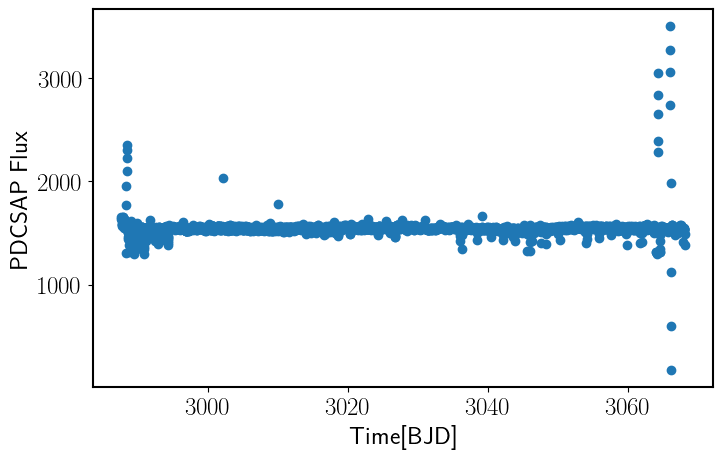

In [57]:
plt.scatter(k2['Time'].values,k2['PDCSAP_Flux'].values)
plt.xlabel('Time[BJD]')
plt.ylabel('PDCSAP Flux')

In [50]:
k2_time = k2['Time'].values
k2_flux = k2['PDCSAP_Flux'].values

In [53]:
lcmedian = (k2_flux/np.nanmedian(k2_flux))-1
lcmedian

array([ 0.07260861,  0.05795866,  0.05219961, ..., -0.00938099,
       -0.03480843, -0.10300557])

Text(0, 0.5, 'Relative Flux')

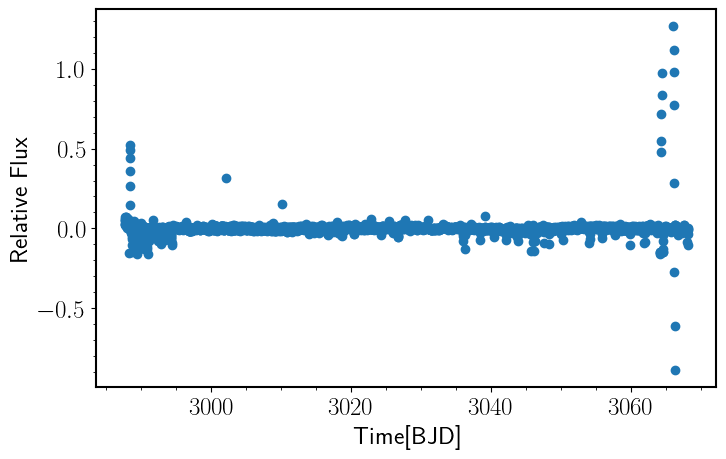

In [59]:
plt.scatter(k2_time,lcmedian)
plt.minorticks_on()
plt.xlabel('Time[BJD]')
plt.ylabel('Relative Flux')

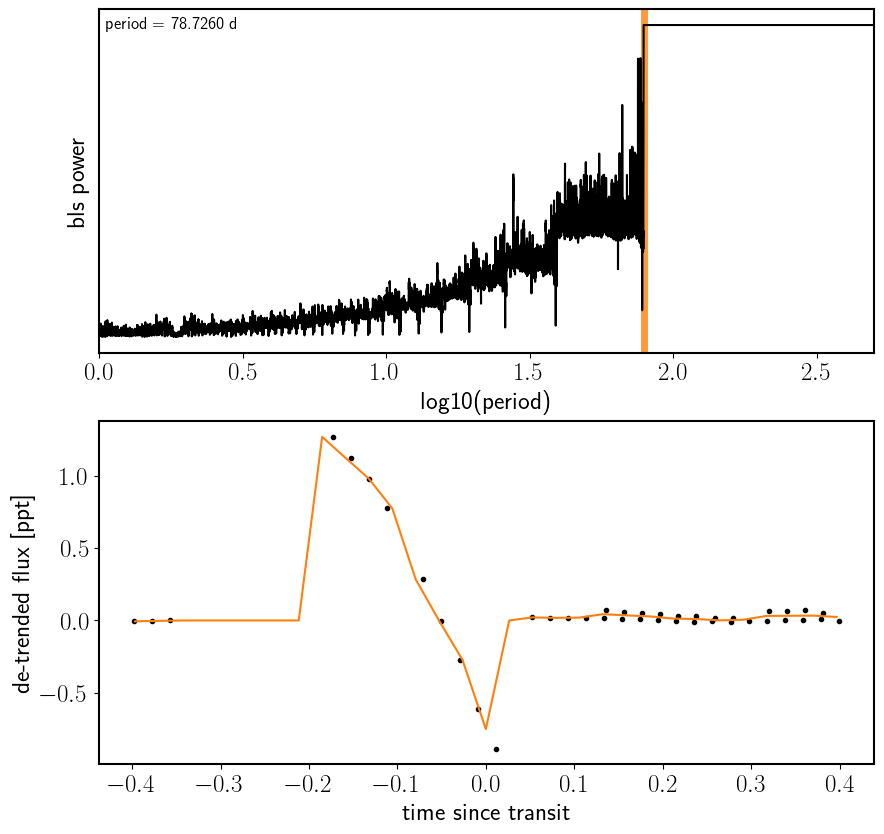

In [66]:
from astropy.timeseries import BoxLeastSquares

period_grid = np.exp(np.linspace(np.log(1), np.log(500), 50000))

bls = BoxLeastSquares(k2_time,lcmedian)
bls_power = bls.power(period_grid, 0.1, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(k2_time, bls_period, 0.2, bls_t0)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")
ax.annotate(
    "period = {0:.4f} d".format(bls_period),
    (0, 1),
    xycoords="axes fraction",
    xytext=(5, -5),
    textcoords="offset points",
    va="top",
    ha="left",
    fontsize=12,
)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transit
ax = axes[1]
x_fold = (k2_time - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
m = np.abs(x_fold) < 0.4
ax.plot(x_fold[m], lcmedian[m], ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 32)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=lcmedian)
denom[num == 0] = 1.0
ax.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, color="C1")

#ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux [ppt]")
_ = ax.set_xlabel("time since transit")

# TESS Data

In [2]:
star = lk.search_lightcurve('EPIC 246711015',author='SPOC')
star

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 05,2018,SPOC,120,303676760,0.0
1,TESS Sector 32,2020,SPOC,120,303676760,0.0


In [3]:
lc = star.download_all()
#lc

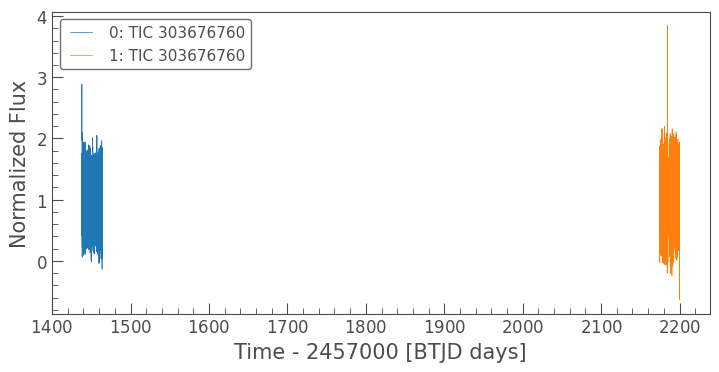

In [4]:
lc.plot(normalize=True);

Text(0.5, 1.0, 'Sector 32')

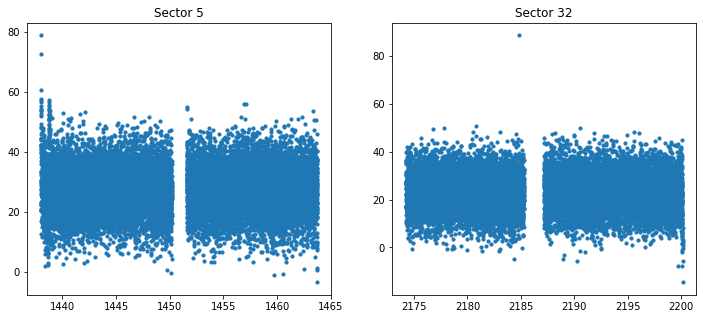

In [8]:
fig,axs = plt.subplots(1,2, figsize=(12,5), facecolor='w', edgecolor='k')
axs[0].scatter(lc[0].time.btjd,lc[0].flux,s=10)
axs[0].set_title('Sector 5')

axs[1].scatter(lc[1].time.btjd,lc[1].flux,s=10)
axs[1].set_title('Sector 32')


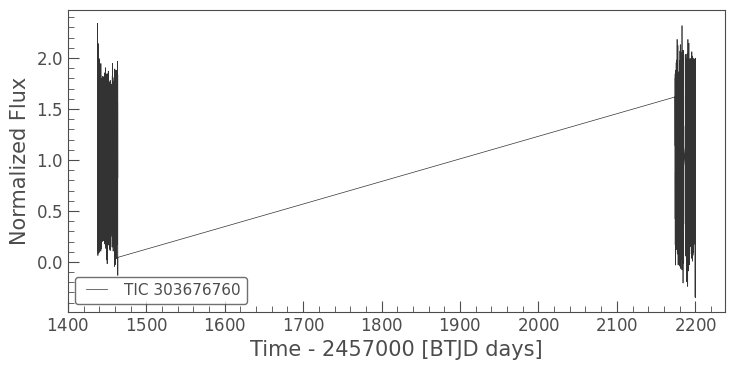

In [9]:
# Flatten the light curve
lc_flat = lc.stitch().flatten(window_length=901).remove_outliers()
lc_flat.plot();

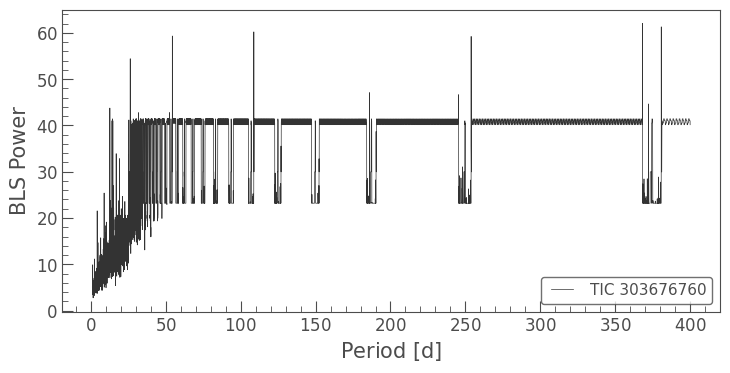

In [10]:
# Create array of periods to search
period = np.linspace(1, 400, 10000)
# Create a BLSPeriodogram
bls = lc_flat.to_periodogram(method='bls', period=period, frequency_factor=500);
bls.plot();

In [11]:
#noise = np.random.normal(500, 100, 500)
#plt.plot(noise)

In [12]:
#plt.plot(bls.period,bls.power)
#plt.plot(noise)

In [13]:
bls.period_at_max_power.value


368.1965196519652

In [14]:
planet_period = bls.period_at_max_power
planet_t0 = bls.transit_time_at_max_power
planet_dur = bls.duration_at_max_power

# Check the value for period
planet_period

<Quantity 368.19651965 d>

In [15]:
planet_t0.value

1463.748414302394

In [16]:
planet_period.value

368.1965196519652

In [17]:
bls.depth_at_max_power

<Quantity 0.7306021>

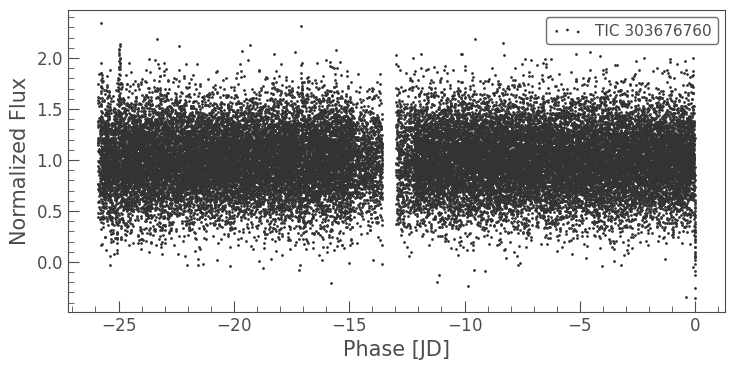

In [19]:
ax = lc_flat.fold(period=planet_period, epoch_time=planet_t0).scatter()
#ax.set_xlim(-1, 1);

In [20]:
# Create a cadence mask using the BLS parameters
planet_mask = bls.get_transit_mask(period=planet_period,
                                     transit_time=planet_t0,
                                     duration=planet_dur)

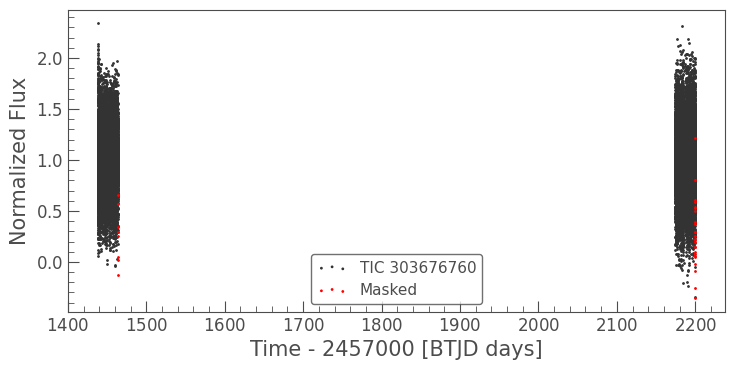

In [23]:
masked_lc = lc_flat[~planet_mask]
ax = masked_lc.scatter();
lc_flat[planet_mask].scatter(ax=ax, c='r', label='Masked');
#ax.set_xlim(2200,2201);

In [24]:
# Create a BLS model using the BLS parameters
planet_model = bls.get_transit_model(period=planet_period,
                                       transit_time=planet_t0,
                                       duration=planet_dur)

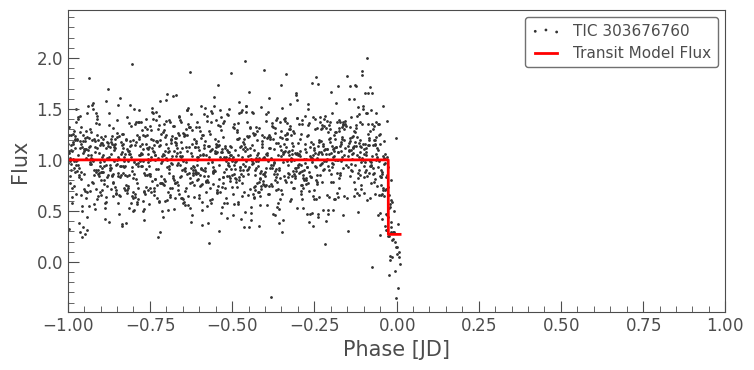

In [26]:
ax = lc_flat.fold(planet_period, planet_t0).scatter()
planet_model.fold(planet_period, planet_t0).plot(ax=ax, c='r', lw=2)
ax.set_xlim(-1, 1);

In [21]:
lc_flat.interact_bls()

Extra planet signals?

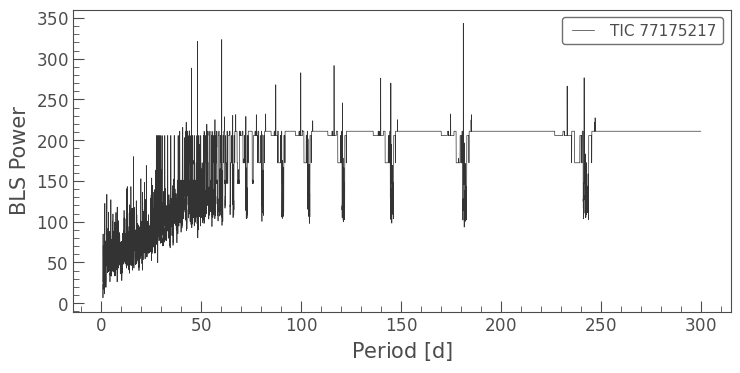

In [22]:
period2 = np.linspace(1, 300, 10000)
bls2 = masked_lc.to_periodogram('bls', period=period2, frequency_factor=500)
bls2.plot();

In [23]:
planet_c_period = bls2.period_at_max_power
planet_c_t0 = bls2.transit_time_at_max_power
planet_c_dur = bls2.duration_at_max_power

# Check the value for period
planet_c_period

<Quantity 181.25522552 d>

<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

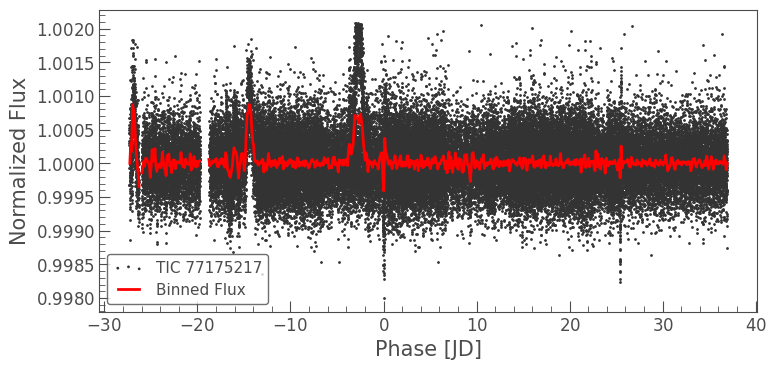

In [24]:
ax = masked_lc.fold(planet_c_period, planet_c_t0).scatter()
masked_lc.fold(planet_c_period, planet_c_t0).bin(.1).plot(ax=ax, c='r', lw=2,
                                                          label='Binned Flux')
#ax.set_xlim(-5, 5);

In [25]:
planet_c_model = bls.get_transit_model(period=planet_c_period,
                                       transit_time=planet_c_t0,
                                       duration=planet_c_dur)

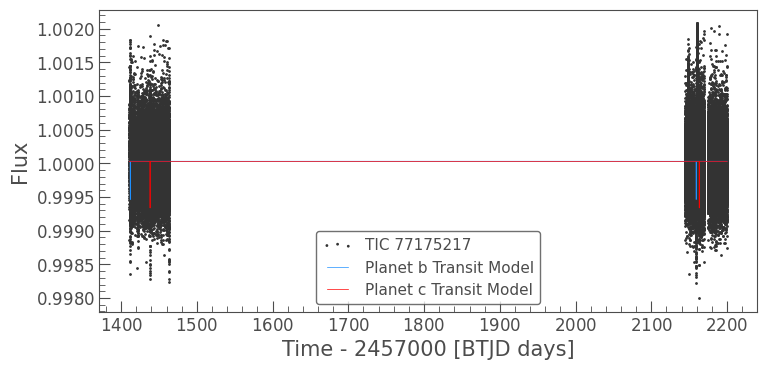

In [26]:
ax = lc_flat.scatter();
planet_model.plot(ax=ax, c='dodgerblue', label='Planet b Transit Model');
planet_c_model.plot(ax=ax, c='r', label='Planet c Transit Model');

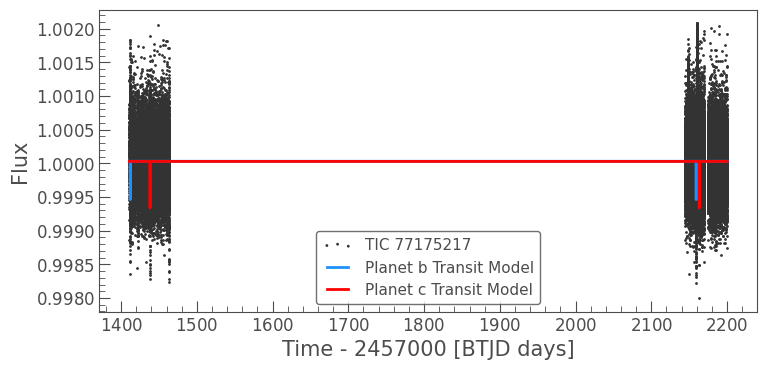

In [27]:
ax = lc_flat.scatter();
planet_model.plot(ax=ax, c='dodgerblue', label='Planet b Transit Model',lw=2);
planet_c_model.plot(ax=ax, c='r', label='Planet c Transit Model',lw=2);
#ax.set_xlim(1410,1415)

#ax.set_xlim(1435,1440)

(1410.0, 1415.0)

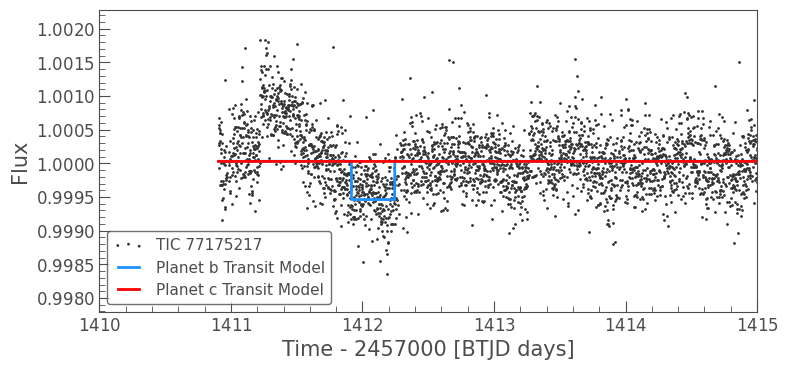

In [28]:
ax = lc_flat.scatter();
planet_model.plot(ax=ax, c='dodgerblue', label='Planet b Transit Model',lw=2);
planet_c_model.plot(ax=ax, c='r', label='Planet c Transit Model',lw=2);
ax.set_xlim(1410,1415)

#ax.set_xlim(1435,1440)

(1438.0, 1440.0)

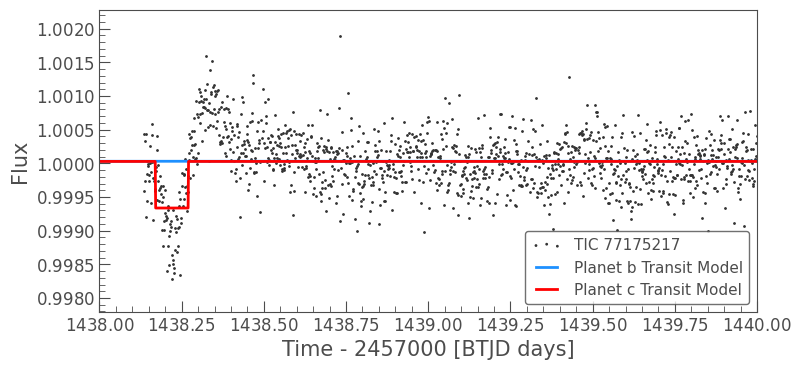

In [29]:
ax = lc_flat.scatter();
planet_model.plot(ax=ax, c='dodgerblue', label='Planet b Transit Model',lw=2);
planet_c_model.plot(ax=ax, c='r', label='Planet c Transit Model',lw=2);
ax.set_xlim(1438,1440)

#ax.set_xlim(1435,1440)

(2157.0, 2165.0)

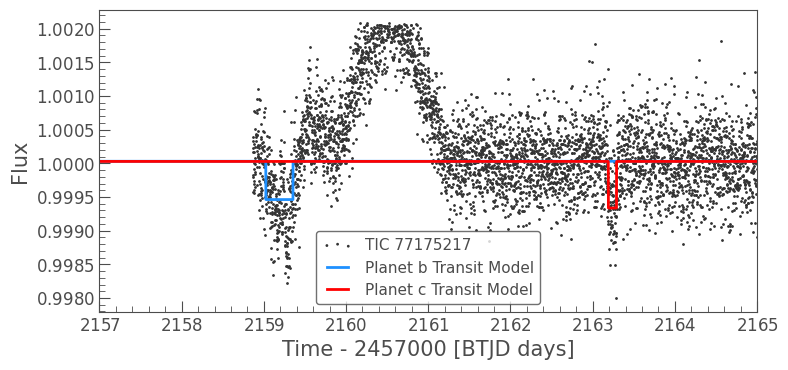

In [30]:
ax = lc_flat.scatter();
planet_model.plot(ax=ax, c='dodgerblue', label='Planet b Transit Model',lw=2);
planet_c_model.plot(ax=ax, c='r', label='Planet c Transit Model',lw=2);
ax.set_xlim(2157,2165)

#ax.set_xlim(1435,1440)

Fitting a transit model using the exoplanet/PyMC3 framework: https://gallery.exoplanet.codes/tutorials/transit/#the-transit-model-in-pymc3

In [31]:
#import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx

In [37]:
from celerite2.theano import terms, GaussianProcess
import exoplanet as xo
import pymc3 as pm
import aesara_theano_fallback.tensor as tt

import pymc3_ext as pmx
from celerite2.theano import terms, GaussianProcess

AttributeError: module 'theano' has no attribute 'Op'

In [33]:
print(planet_period,planet_c_period)

67.91899189918992 d 181.25522552255225 d


In [34]:
np.log(bls.depth_at_max_power)

<Quantity -7.47213913>

In [ ]:
periods = [67.91899189918992 , 181.25522552255225]
t0s = periods * np.random.rand(2)
t = lc_flat.time.btjd
y=lc_flat.flux.value
yerr = lc_flat.flux_err.value

In [ ]:
t0s

In [ ]:
bls_depth = bls.depth_at_max_power
bls_depth

In [ ]:
phase_lc = np.linspace(-1, 1, 100)

In [ ]:
def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(t), dtype=bool)
        
    with pm.Model() as model:
        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.QuadLimbDark("u_star")
        star = xo.LimbDarkLightCurve(u_star)

        # Stellar parameters from TFOP
        M_star = 0.286,0.020
        R_star = 0.308,0.009
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal(
            "m_star", mu=M_star[0], sd=M_star[1]
        )
        r_star = BoundedNormal(
            "r_star", mu=R_star[0], sd=R_star[1]
        )

        # Orbital parameters for the planets
        t0 = pm.Normal("t0", mu=planet_t0.value, sd=1)
        log_period = pm.Normal("log_period", mu=np.log(planet_period.value), sd=1)
        period = pm.Deterministic("period", pm.math.exp(log_period))

        # Fit in terms of transit depth (assuming b<1)
        b = pm.Uniform("b", lower=0, upper=2)
        log_depth = pm.Normal("log_depth", mu=np.log(bls_depth), sigma=2.0)
        ror = pm.Deterministic(
            "ror",
            star.get_ror_from_approx_transit_depth(
                1e-3 * pm.math.exp(log_depth), b
            ),
        )
        r_pl = pm.Deterministic("r_pl", ror * r_star)
        
        ecs = pmx.UnitDisk("ecs", testval=np.array([0.01, 0.0]))
        ecc = pm.Deterministic("ecc", pm.math.sum(ecs**2))
        omega = pm.Deterministic("omega", pm.math.arctan2(ecs[1], ecs[0]))
        xo.eccentricity.kipping13("ecc_prior", fixed=True, observed=ecc)

        # Transit jitter & GP parameters
        log_sigma_lc = pm.Normal(
            "log_sigma_lc", mu=np.log(np.std(y[mask])), sd=10
        )
        log_rho_gp = pm.Normal("log_rho_gp", mu=0, sd=10)
        log_sigma_gp = pm.Normal(
            "log_sigma_gp", mu=np.log(np.std(y[mask])), sd=10
        )

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            ecc=ecc,
            omega=omega,
        )

        # Compute the model light curve
        light_curves = (
            star.get_light_curve(orbit=orbit, r=r_pl, t=t[mask], texp=texp)
            * 1e3
        )
        light_curve = pm.math.sum(light_curves, axis=-1) + mean
        resid = y[mask] - light_curve

        # GP model for the light curve
        kernel = terms.SHOTerm(
            sigma=pm.math.exp(log_sigma_gp),
            rho=pm.math.exp(log_rho_gp),
            Q=1 / np.sqrt(2),
        )
        gp = GaussianProcess(kernel, t=t[mask], yerr=pm.math.exp(log_sigma_lc))
        gp.marginal("gp", observed=resid)
        #         pm.Deterministic("gp_pred", gp.predict(resid))

        # Compute and save the phased light curve models
        pm.Deterministic(
            "lc_pred",
            1e3
            * star.get_light_curve(
                orbit=orbit, r=r_pl, t=t0 + phase_lc, texp=texp
            )[..., 0],
        )

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = pmx.optimize(
            start=start, vars=[log_sigma_lc, log_sigma_gp, log_rho_gp]
        )
        map_soln = pmx.optimize(start=map_soln, vars=[log_depth])
        map_soln = pmx.optimize(start=map_soln, vars=[b])
        map_soln = pmx.optimize(start=map_soln, vars=[log_period, t0])
        map_soln = pmx.optimize(start=map_soln, vars=[u_star])
        map_soln = pmx.optimize(start=map_soln, vars=[log_depth])
        map_soln = pmx.optimize(start=map_soln, vars=[b])
        map_soln = pmx.optimize(start=map_soln, vars=[ecs])
        map_soln = pmx.optimize(start=map_soln, vars=[mean])
        map_soln = pmx.optimize(
            start=map_soln, vars=[log_sigma_lc, log_sigma_gp, log_rho_gp]
        )
        map_soln = pmx.optimize(start=map_soln)

        extras = dict(
            zip(
                ["light_curves", "gp_pred"],
                pmx.eval_in_model([light_curves, gp.predict(resid)], map_soln),
            )
        )

    return model, map_soln, extras
model0, map_soln0, extras0 = build_model()

In [ ]:
plt.plot(t, lc_flat.flux, ".k", ms=4, label="data")
for i, l in enumerate("bc"):
    plt.plot(
        t, map_soln["light_curves"][:, i], lw=1, label="planet {0}".format(l)
    )
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
_ = plt.title("map model")